In [1]:
import cv2
import scipy
import matplotlib.pyplot as plt
import numpy as np

[[88. 88. 88. ... 88. 88. 88.]
 [88. 88. 88. ... 88. 88. 88.]
 [88. 88. 88. ... 88. 88. 88.]
 ...
 [88. 88. 88. ... 88. 88. 88.]
 [88. 88. 88. ... 88. 88. 88.]
 [88. 88. 88. ... 88. 88. 88.]]


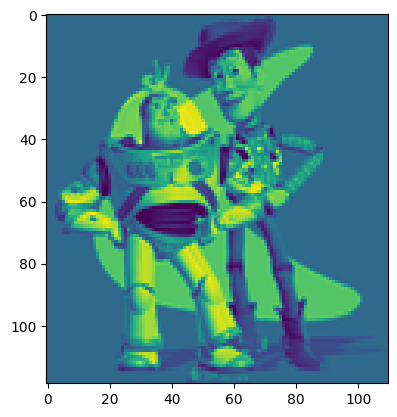

(119, 110)


In [2]:
img = cv2.imread('toy_problem.png') #read image
img = cv2.cvtColor(img, (cv2.COLOR_BGR2GRAY)).astype(float) #convert bgr to rgb
# img = cv2.resize(img, (5,5))
print(img)

plt.imshow(img)
plt.show()
print(img.shape)

[88.00872099 88.01292866 88.01301153 ... 88.16004948 88.16241896
 88.16319666]


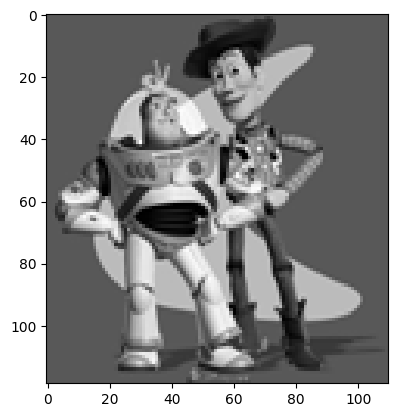

In [3]:
def toy_problem(s):
   # Get image dimensions
    h, w = s.shape
    
    # Create im2ind matrix
    im2ind = np.reshape(np.arange(0, h*w), [h, w])

    # Initialize sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((2*h*w + 1, h*w))
    b = np.zeros(2*h*w + 1)
    # Populate A and b with constraints for gradient objectives
    e = 0  # equation counter
    for i in range(h):
        for j in range(w):
            # Objective 1
            if j > 0:
                e += 1
                A[e, im2ind[i, j]] = 1
                A[e, im2ind[i, j-1]] = -1
                b[e] = s[i, j] - s[i, j-1]

            # Objective 2
            if i > 0:
                e += 1
                A[e, im2ind[i, j]] = 1
                A[e, im2ind[i-1, j]] = -1
                b[e] = s[i, j] - s[i-1, j]

    # Add the third objective
    e += 1
    A[e, im2ind[0, 0]] = 1
    b[e] = s[0, 0]

    # Solve for variables v
    v = scipy.sparse.linalg.lsqr(A, b)[0]

    # Create output image using solved values
    output_image = np.reshape(v, [h, w])
    # print(im2ind)
    print(v)
    # print(b)

    return output_image

plt.imshow(toy_problem(img), cmap = 'gray')

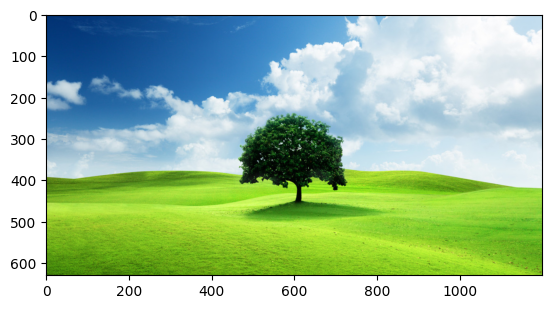

In [4]:
tree_img = cv2.imread('tree_image.jpg')
rgb_tree_img = cv2.cvtColor(tree_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_tree_img)

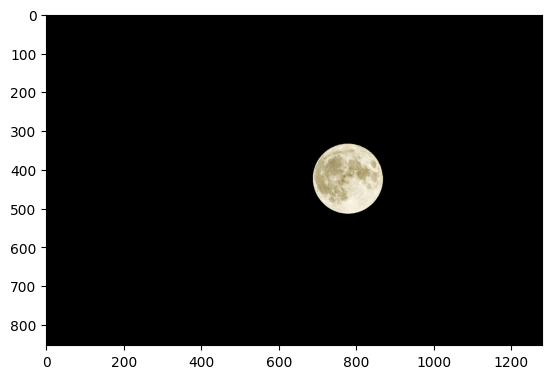

In [5]:
moon_img = cv2.imread('moon.jpg')
gray = cv2.cvtColor(moon_img, cv2.COLOR_BGR2GRAY)

# Apply thresholding to the grayscale image
_, thresh = cv2.threshold(gray, 100, 180, cv2.THRESH_BINARY)

# Create a mask from the thresholded image
mask = np.zeros_like(thresh, dtype=np.uint8)
mask[thresh > 0] = 255

# Apply the mask to the original image
masked_image = cv2.bitwise_and(moon_img, moon_img, mask=mask)
plt.imshow(masked_image)

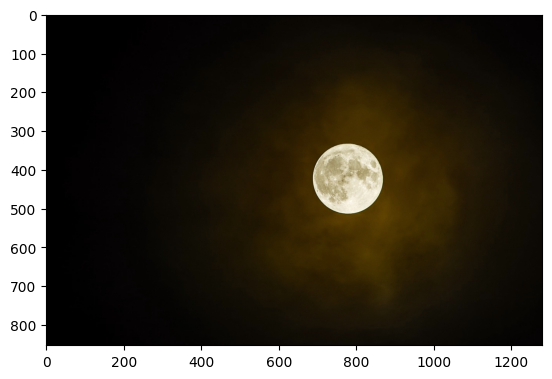

In [6]:
plt.imshow(moon_img)

In [7]:
print(moon_img.shape)
print(mask.shape)
print(masked_image.shape)
print(tree_img.shape)
moon_img = cv2.resize()

(853, 1280, 3)
(853, 1280)
(853, 1280, 3)
(630, 1200, 3)


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - resize() missing required argument 'src' (pos 1)
>  - resize() missing required argument 'src' (pos 1)
